# Imports

In [1]:
import os
import pydotplus
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from IPython.display import Image
%matplotlib inline

In [2]:
nepal = gpd.read_file('Data/nepaldistricts/NP_75DWGS84.shp')
nepal.set_index('DISTRICT', inplace=True)
nepal.head()

,DISS,DIST_ID,REGION,Xc,Yc,ZONE_NAME,geometry
DISTRICT,,,,,,,
Taplejung,100,1,Eastern,87.8217,27.5822,Mechi,"POLYGON ((87.83400591558305 27.95177382643147,..."
Panchthar,100,2,Eastern,87.7757,27.1151,Mechi,"POLYGON ((88.07355798392611 27.43371902876805,..."
Ilam,100,3,Eastern,87.9014,26.8813,Mechi,"POLYGON ((87.9948791435361 27.10367669091931, ..."
Jhapa,100,4,Eastern,87.9131,26.5847,Mechi,"POLYGON ((88.15219918939425 26.80604174199942,..."
Morang,100,5,Eastern,87.4701,26.6176,Koshi,"POLYGON ((87.5069571072476 26.87060266868053, ..."


# Define Nepal Analysis

In [3]:
class nepal_analysis(object):
    def __init__(self, data_path, condition, min_leaf, max_depth, full):
        self.condition = condition
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        
        # Load and store dataframe.
        df = pd.read_csv(data_path, index_col='Unnamed: 0')
        self.df = df.rename(columns= lambda x: x.replace(
                ' ', '').replace('/', '').replace('-', '').replace(
                '(', '').replace(')', '').replace('%', '').replace(
                '<', '').replace('\n', ''))   
        
        # Store X & Y values based on condition & full or simplified data.
        self.Y = self.df[self.condition]
        
        if full == True:
            full_X_cols = ['Foreigner', 'HillBrahman', 'HillChhetree', 'HillDalit',
                           'MadhesiBrahmanChhetree', 'MadhesiDalit', 'MadhesiOtherOCA',
                           'MadhesiOtherOCB', 'MtnHillJanajatiA', 'MtnHillJanajatiB',
                           'Musalman', 'Newar', 'OtherMPB', 'Otherundefined', 'TaraiJanajati',
                           'PovertySeverity', 'Adultilliteracyrate', 'Children5yearsmalnourished', 
                           'SanitationCoverage', 'SexRatiomaleper100female', 'Vacc_Access']
            self.X = self.df[full_X_cols]
        
        if full == False:
            sim_X_cols = ['PovertySeverity', 'Adultilliteracyrate', 'Children5yearsmalnourished', 
                          'SanitationCoverage', 'SexRatiomaleper100female', 'caste_diversity', 
                          'Vacc_Access']
            self.X = self.df[sim_X_cols]
    
    def rfr_(self):
        # Create & fit RFR
        rfr = RandomForestRegressor(n_estimators=100,
                                    oob_score=True,
                                    random_state=1,
                                    min_samples_leaf=self.min_leaf,
                                    max_depth=self.max_depth)
        self.rfr = rfr.fit(self.X, self.Y)
        
        # Get significant features
        self.rfr_sig = filter(lambda x: x[1] > 0,
                              sorted(zip(self.X.columns,[round(i, 4) for i in self.rfr.feature_importances_]
                                        ), key=lambda x: x[1], reverse=True))
        
        # Create MSE dataframe
        rfr_mse = pd.DataFrame()
        rfr_mse['Obs'] = self.Y
        rfr_mse['Pred'] = self.rfr.predict(self.X)
        rfr_mse['Diff'] = rfr_mse['Obs'] - rfr_mse['Pred']
        rfr_mse['DiffSqr'] = rfr_mse['Diff'] ** 2
        rfr_mse['DiffSqrNorm'] = (rfr_mse['DiffSqr'] - rfr_mse['DiffSqr'].mean()) / rfr_mse['DiffSqr'].std()
        
        # Outputs
        rfr_score = self.rfr.score(self.X, self.Y)
        oob_score = (self.rfr.oob_score_)
        
        print ('Random Forest Score: {0}\nOOB Score: {1}'.format(rfr_score, oob_score))
        return (rfr_score, oob_score, self.rfr_sig, rfr_mse)
    
    def dtr_(self, width=400):
        # Create & gridSearch fit DTR
        dtr_sim = DecisionTreeRegressor(random_state=1,
                                        min_samples_leaf=self.min_leaf,
                                        max_depth=self.max_depth)
        X_sig = self.X[map(lambda x: x[0], self.rfr_sig)]
        
        if X_sig.empty:
            print 'No significant features from RFR'
            return (None, None, None)
        
        gs = GridSearchCV(estimator=dtr_sim, param_grid={'max_leaf_nodes': range(3, 20)})
        gs.fit(X_sig, self.Y)
        self.dtr = gs.best_estimator_
        
        # Create DTR graph
        dot_data = export_graphviz(
            self.dtr, feature_names=X_sig.columns,
            out_file=None, filled=True, rounded=True,
            special_characters=True)  
        graph = pydotplus.graph_from_dot_data(dot_data)  
        self.dtr_img = Image(graph.create_png(), width=width) 
        
        # Create MSE dataframe
        dtr_mse = pd.DataFrame()
        dtr_mse['Obs'] = self.Y
        dtr_mse['Pred'] = self.dtr.predict(X_sig)
        dtr_mse['Diff'] = dtr_mse['Obs'] - dtr_mse['Pred']
        dtr_mse['DiffSqr'] = dtr_mse['Diff'] ** 2
        dtr_mse['DiffSqrNorm'] = (dtr_mse['DiffSqr'] - dtr_mse['DiffSqr'].mean()) / dtr_mse['DiffSqr'].std()
        
        # Outputs
        dtr_score = self.dtr.score(X_sig, self.Y)
        
        print ('Decision Tree Score: {}'.format(dtr_score))
        return (dtr_score, self.dtr_img, dtr_mse)

# Get Scores For Full Dataset 2009-2013

In [4]:
path = '/Users/kristikorsberg/Downloads/master0913.csv'
#path = 'Data/master0913.csv'

Y_cols = ['ConfirmedMeningitis3', 'HIVAIDS3', 'Leprosy3', 
          'STDSTI3', 'AnxietyNeurosis', 'Conversivedisorder\rHysteria', 
          'Depression', 'Epilesy', 'Mentalretardation', 'Psychosis']

rfr_score_avg = []
oob_avg = []
dtr_score_avg = []

for feature in Y_cols:
    print '\n', feature 
    obj = nepal_analysis(path, feature, 8, 2, True)
    rfr_score, oob, sig, rfr_mse = obj.rfr_()
    dtr_score, img, dtr_mse = obj.dtr_()
    rfr_score_avg.append(rfr_score)
    oob_avg.append(oob)
    dtr_score_avg.append(dtr_score)

print '\nAvg RFR score: '+str(sum(rfr_score_avg)/len(rfr_score_avg))
print 'Avg OOB score: '+str(sum(oob_avg)/len(oob_avg))
print 'Avg DTR score: '+str(sum(dtr_score_avg)/len(dtr_score_avg))


ConfirmedMeningitis3
Random Forest Score: 0.166794358116
OOB Score: 0.00721403997057
Decision Tree Score: 0.217827808591

HIVAIDS3
Random Forest Score: 0.321851353484
OOB Score: 0.128935118067
Decision Tree Score: 0.367711635703

Leprosy3
Random Forest Score: 0.14103204294
OOB Score: -0.000591611500659
Decision Tree Score: 0.155592761848

STDSTI3
Random Forest Score: 0.254053090436
OOB Score: 0.0623431016136
Decision Tree Score: 0.320264656309

AnxietyNeurosis
Random Forest Score: 0.444507094719
OOB Score: 0.325889291009
Decision Tree Score: 0.344474748236

Hysteria
Random Forest Score: 0.250125399037
OOB Score: 0.0766993280816
Decision Tree Score: 0.284432795729

Depression
Random Forest Score: 0.461388447747
OOB Score: 0.304101979441
Decision Tree Score: 0.554898904325

Epilesy
Random Forest Score: 0.34608385252
OOB Score: 0.178971733145
Decision Tree Score: 0.578938327923

Mentalretardation
Random Forest Score: 0.179124372467
OOB Score: -0.00295272502549
Decision Tree Score: 0.1043

# Best Model From Above

Random Forest Score: 0.444507094719
OOB Score: 0.325889291009
Decision Tree Score: 0.344474748236


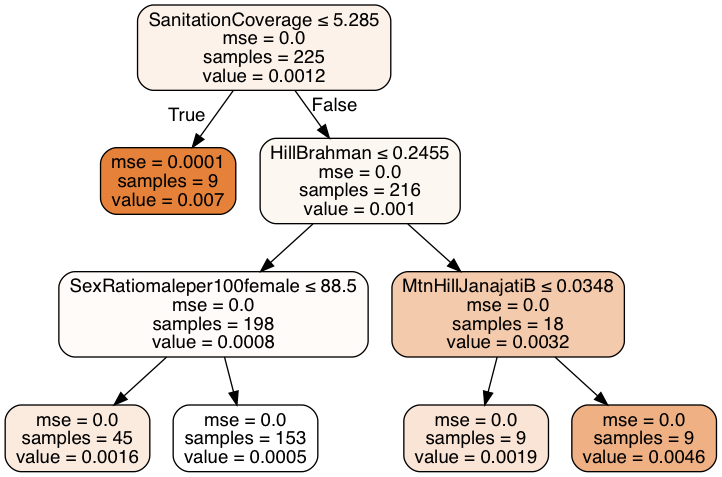

In [5]:
path = '/Users/kristikorsberg/Downloads/master0913.csv'
obj = nepal_analysis(path, 'AnxietyNeurosis', 8, 2, True)
rfr_score, oob, sig, rfr_mse = obj.rfr_()
drt_score, img, dtr_mse = obj.dtr_(width=600)
img

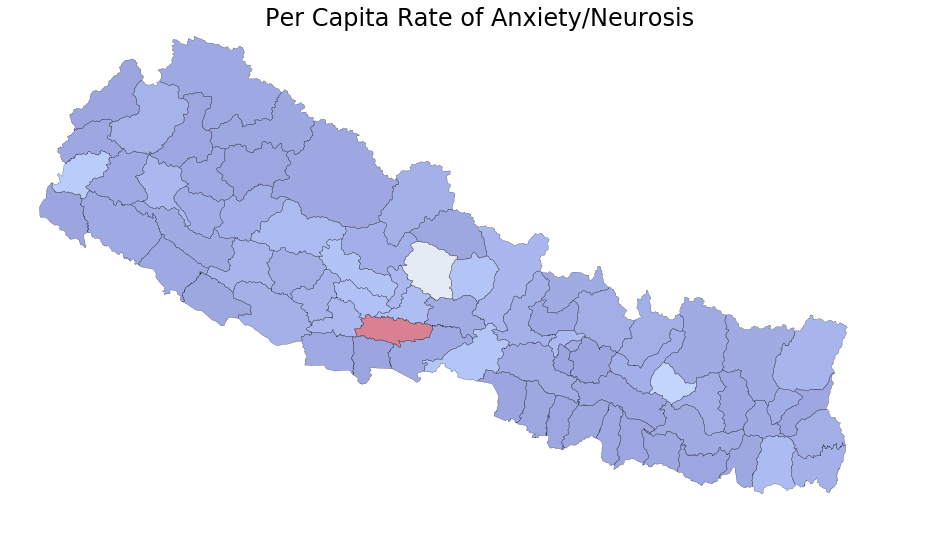

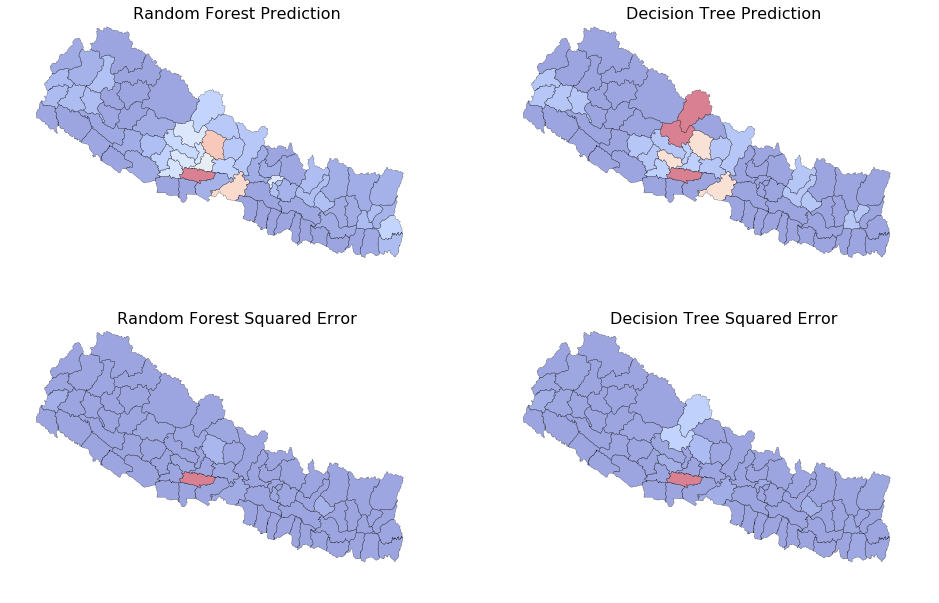

In [6]:
rfr_join = nepal.join(rfr_mse.groupby(rfr_mse.index).mean())
dtr_join = nepal.join(dtr_mse.groupby(dtr_mse.index).mean())

fig, (ax1) = plt.subplots(figsize=(16, 9))
rfr_join.plot(column='Obs', cmap='coolwarm', linewidth=0.2, ax=ax1)
ax1.set_title('Per Capita Rate of Anxiety/Neurosis', size=24)
ax1.axis('off')

fig, ((ax1, ax2),
      (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
rfr_join.plot(column='Pred', cmap='coolwarm', linewidth=0.2, ax=ax1)
ax1.set_title('Random Forest Prediction', size=16)
dtr_join.plot(column='Pred', cmap='coolwarm', linewidth=0.2, ax=ax2)
ax2.set_title('Decision Tree Prediction', size=16)
rfr_join.plot(column='DiffSqr', cmap='coolwarm', linewidth=0.2, ax=ax3)
ax3.set_title('Random Forest Squared Error', size=16)
dtr_join.plot(column='DiffSqr', cmap='coolwarm', linewidth=0.2, ax=ax4)
ax4.set_title('Decision Tree Squared Error', size=16)

for ax in fig.axes:
    ax.axis('off')

In [7]:
mean = rfr_mse.groupby(rfr_mse.index).mean()
print sum([elem for elem in mean['DiffSqr']])/len(mean)
mean[mean['DiffSqr']==min(mean['DiffSqr'])]

3.44394020408e-06


,Obs,Pred,Diff,DiffSqr,DiffSqrNorm
Dailekh,0.000708,0.000628,0.00008,8.390142e-09,-0.14469


In [8]:
mean = dtr_mse.groupby(dtr_mse.index).mean()
print sum([elem for elem in mean['DiffSqr']])/len(mean)
mean[mean['DiffSqr']==min(mean['DiffSqr'])]

4.06411989762e-06


,Obs,Pred,Diff,DiffSqr,DiffSqrNorm
Udayapur,0.000444,0.000528,-0.000084,1.011011e-08,-0.184762


# Get Scores For Full Dataset Other Condition 2009-2011

In [9]:
path = '/Users/kristikorsberg/Downloads/master0911.csv'

Y_cols = ['AcuteFlacidParalysis', 'Chickenpox', 'Diptheria',
          'HepatatisB', 'Measles', 'Mumps', 'NeonatalTetanus',
          'Rubella', 'Tetanus', 'Tuberculosis', 'Whoopingcough',
          'Alcoholism', 'Conversivedisorder\rHysteria']

rfr_score_avg = []
oob_avg = []
dtr_score_avg = []

for feature in Y_cols:
    print '\n', feature 
    obj = nepal_analysis(path, feature, 8, 2, True)
    rfr_score, oob, sig, rfr_mse = obj.rfr_()
    dtr_score, img, dtr_mse = obj.dtr_()
    rfr_score_avg.append(rfr_score)
    oob_avg.append(oob)
    dtr_score_avg.append(dtr_score)

dtr_score_avg = filter(None, dtr_score_avg)
print '\nAvg RFR score: '+str(sum(rfr_score_avg)/len(rfr_score_avg))
print 'Avg OOB score: '+str(sum(oob_avg)/len(oob_avg))
print 'Avg DTR score: '+str(sum(dtr_score_avg)/len(dtr_score_avg))


AcuteFlacidParalysis
Random Forest Score: -3.33098244543e-07
OOB Score: -0.0152608781022
No significant features from RFR

Chickenpox
Random Forest Score: 0.48359070852
OOB Score: 0.28526786552
Decision Tree Score: 0.553131570481

Diptheria
Random Forest Score: -0.000129246276898
OOB Score: -0.0139485544276
No significant features from RFR

HepatatisB
Random Forest Score: -8.76123578131e-08
OOB Score: -0.0141018740492
No significant features from RFR

Measles
Random Forest Score: -2.94682906197e-05
OOB Score: -0.0146686018168
No significant features from RFR

Mumps
Random Forest Score: 0.490437179834
OOB Score: 0.283265283018
Decision Tree Score: 0.491730686452

NeonatalTetanus
Random Forest Score: -1.19740423914e-05
OOB Score: -0.0122297452506
No significant features from RFR

Rubella
Random Forest Score: -6.45604075544e-05
OOB Score: -0.0120368218034
No significant features from RFR

Tetanus
Random Forest Score: -5.33179890116e-05
OOB Score: -0.0162178132514
No significant features 

# Best Model From Above

Random Forest Score: 0.48359070852
OOB Score: 0.28526786552
Decision Tree Score: 0.553131570481


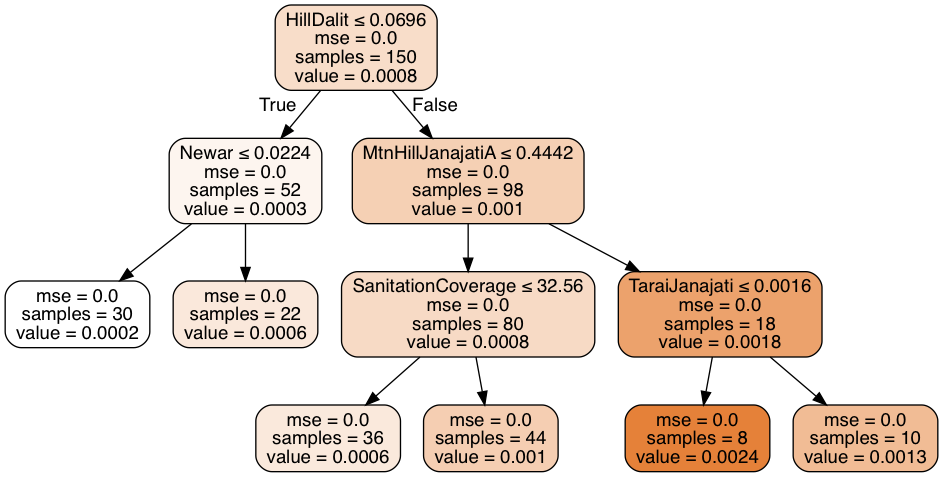

In [10]:
path = '/Users/kristikorsberg/Downloads/master0911.csv'
obj = nepal_analysis(path, 'Chickenpox', 8, 2, True)
rfr_score, oob, sig, rfr_mse = obj.rfr_()
drt_score, img, dtr_mse = obj.dtr_(width=700)
img

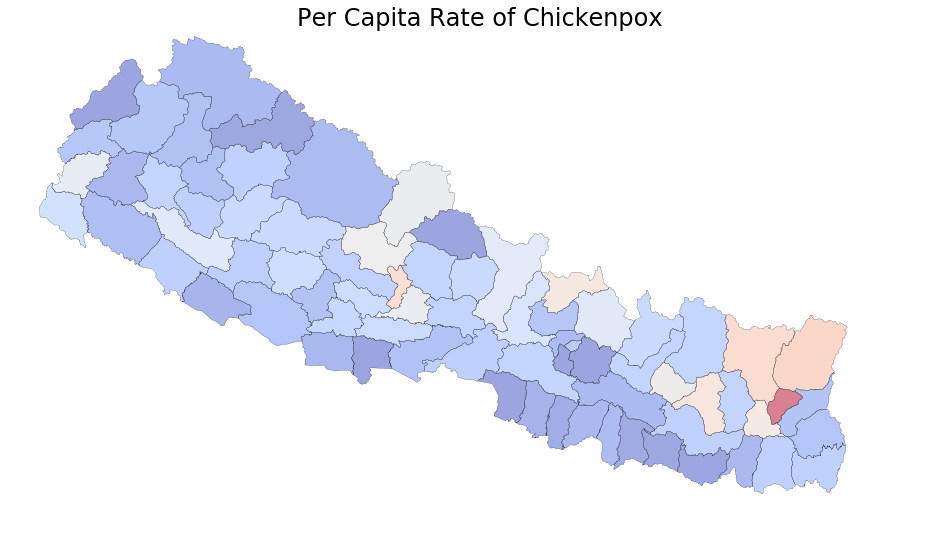

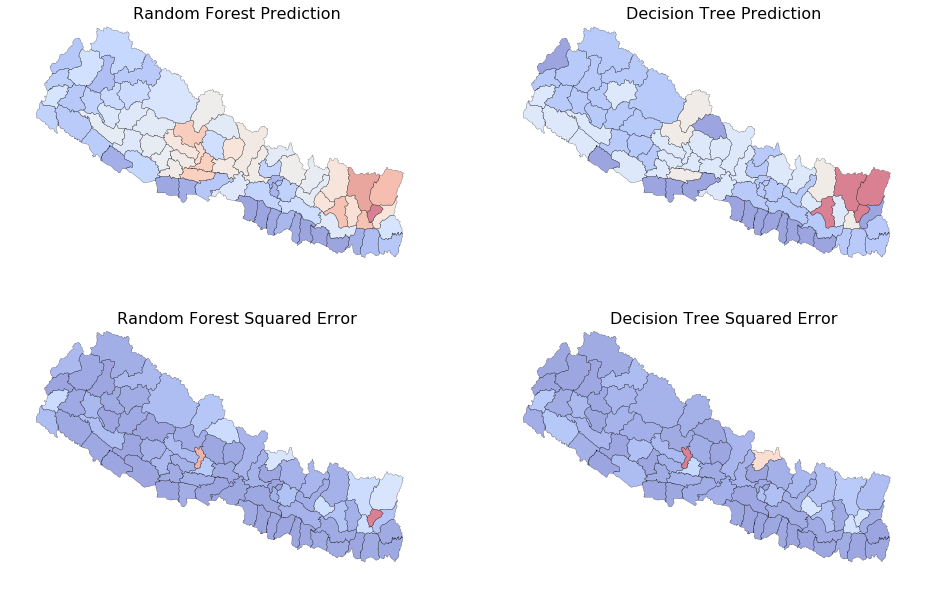

In [11]:
rfr_join = nepal.join(rfr_mse.groupby(rfr_mse.index).mean())
dtr_join = nepal.join(dtr_mse.groupby(dtr_mse.index).mean())

fig, (ax1) = plt.subplots(figsize=(16, 9))
rfr_join.plot(column='Obs', cmap='coolwarm', linewidth=0.2, ax=ax1)
ax1.set_title('Per Capita Rate of Chickenpox', size=24)
ax1.axis('off')

fig, ((ax1, ax2),
      (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
rfr_join.plot(column='Pred', cmap='coolwarm', linewidth=0.2, ax=ax1)
ax1.set_title('Random Forest Prediction', size=16)
dtr_join.plot(column='Pred', cmap='coolwarm', linewidth=0.2, ax=ax2)
ax2.set_title('Decision Tree Prediction', size=16)
rfr_join.plot(column='DiffSqr', cmap='coolwarm', linewidth=0.2, ax=ax3)
ax3.set_title('Random Forest Squared Error', size=16)
dtr_join.plot(column='DiffSqr', cmap='coolwarm', linewidth=0.2, ax=ax4)
ax4.set_title('Decision Tree Squared Error', size=16)

for ax in fig.axes:
    ax.axis('off')

In [12]:
mean = rfr_mse.groupby(rfr_mse.index).mean()
print sum([elem for elem in mean['DiffSqr']])/len(mean)
mean[mean['DiffSqr']==min(mean['DiffSqr'])]

2.50341596881e-07


,Obs,Pred,Diff,DiffSqr,DiffSqrNorm
Baitadi,0.000538,0.000565,-0.000027,7.462983e-10,-0.438707


In [13]:
mean = dtr_mse.groupby(dtr_mse.index).mean()
print sum([elem for elem in mean['DiffSqr']])/len(mean)
mean[mean['DiffSqr']==min(mean['DiffSqr'])]

2.1663002213e-07


,Obs,Pred,Diff,DiffSqr,DiffSqrNorm
Baitadi,0.000538,0.000563,-0.000025,6.443827e-10,-0.408048


In [14]:
rfr_join.to_file('rfr_join_0911_cp.shp',driver='ESRI Shapefile')

In [15]:
dtr_join.to_file('dtr_join_0911_cp.shp',driver='ESRI Shapefile')

# Get Score For 'Diversity' Dataset 2009-2013

In [16]:
Y_cols = ['ConfirmedMeningitis3', 'HIVAIDS3', 'Leprosy3', 
          'STDSTI3', 'AnxietyNeurosis', 
          'Depression', 'Epilesy', 'Mentalretardation', 'Psychosis']

path = '/Users/kristikorsberg/Downloads/simplified_master0913.csv'

rfr_score_avg = []
oob_avg = []
dtr_score_avg = []

for feature in Y_cols:
    print '\n', feature 
    obj = nepal_analysis(path, feature, 8, 2, True)
    rfr_score, oob, sig, rfr_mse = obj.rfr_()
    dtr_score, img, dtr_mse = obj.dtr_()
    rfr_score_avg.append(rfr_score)
    oob_avg.append(oob)
    dtr_score_avg.append(dtr_score)

dtr_score_avg = filter(None, dtr_score_avg)
print '\nAvg RFR score: '+str(sum(rfr_score_avg)/len(rfr_score_avg))
print 'Avg OOB score: '+str(sum(oob_avg)/len(oob_avg))
print 'Avg DTR score: '+str(sum(dtr_score_avg)/len(dtr_score_avg))


ConfirmedMeningitis3
Random Forest Score: 0.166794358116
OOB Score: 0.00721403997057
Decision Tree Score: 0.217827808591

HIVAIDS3
Random Forest Score: 0.321851353484
OOB Score: 0.128935118067
Decision Tree Score: 0.367711635703

Leprosy3
Random Forest Score: 0.14103204294
OOB Score: -0.000591611500659
Decision Tree Score: 0.155592761848

STDSTI3
Random Forest Score: 0.254053090436
OOB Score: 0.0623431016136
Decision Tree Score: 0.320264656309

AnxietyNeurosis
Random Forest Score: 0.444507094719
OOB Score: 0.325889291009
Decision Tree Score: 0.344474748236

Depression
Random Forest Score: 0.461388447747
OOB Score: 0.304101979441
Decision Tree Score: 0.554898904325

Epilesy
Random Forest Score: 0.34608385252
OOB Score: 0.178971733145
Decision Tree Score: 0.578938327923

Mentalretardation
Random Forest Score: 0.179124372467
OOB Score: -0.00295272502549
Decision Tree Score: 0.10438770042

Psychosis
Random Forest Score: 0.351689028778
OOB Score: 0.196838222218
Decision Tree Score: 0.28785

# Best Model From Above

Random Forest Score: 0.416394768256
OOB Score: 0.294323347146
Decision Tree Score: 0.304090638386


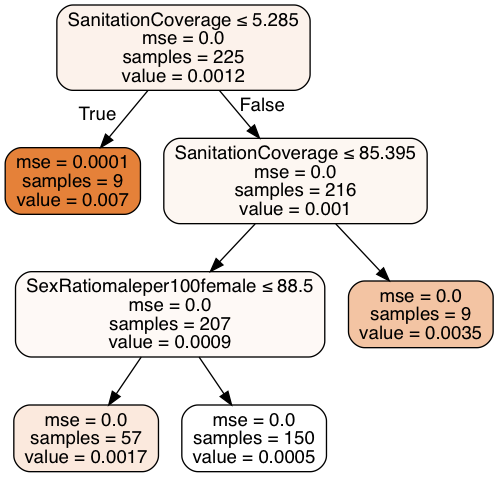

In [17]:
path = '/Users/kristikorsberg/Downloads/simplified_master0913.csv'
obj = nepal_analysis(path, 'AnxietyNeurosis', 8, 2, False)
rfr_score, oob, sig, rfr_mse = obj.rfr_()
drt_score, img, dtr_mse = obj.dtr_(width=600)
img 

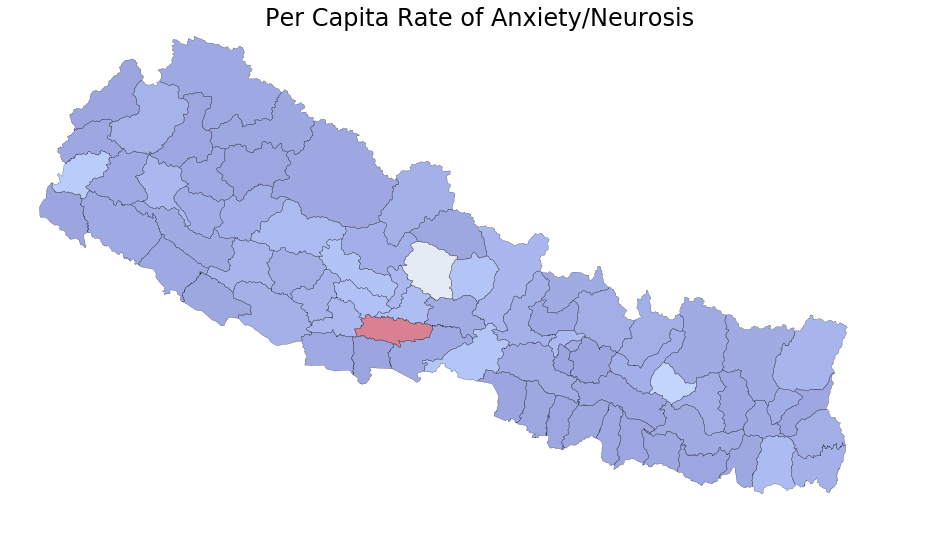

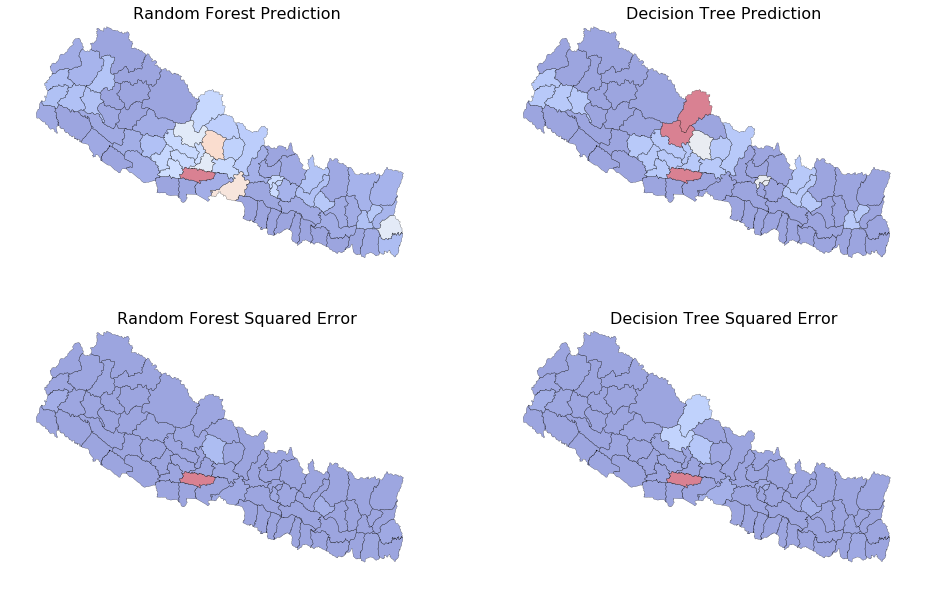

In [18]:
rfr_join = nepal.join(rfr_mse.groupby(rfr_mse.index).mean())
dtr_join = nepal.join(dtr_mse.groupby(dtr_mse.index).mean())

fig, (ax1) = plt.subplots(figsize=(16, 9))
rfr_join.plot(column='Obs', cmap='coolwarm', linewidth=0.2, ax=ax1)
ax1.set_title('Per Capita Rate of Anxiety/Neurosis', size=24)
ax1.axis('off')

fig, ((ax1, ax2),
      (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
rfr_join.plot(column='Pred', cmap='coolwarm', linewidth=0.2, ax=ax1)
ax1.set_title('Random Forest Prediction', size=16)
dtr_join.plot(column='Pred', cmap='coolwarm', linewidth=0.2, ax=ax2)
ax2.set_title('Decision Tree Prediction', size=16)
rfr_join.plot(column='DiffSqr', cmap='coolwarm', linewidth=0.2, ax=ax3)
ax3.set_title('Random Forest Squared Error', size=16)
dtr_join.plot(column='DiffSqr', cmap='coolwarm', linewidth=0.2, ax=ax4)
ax4.set_title('Decision Tree Squared Error', size=16)

for ax in fig.axes:
    ax.axis('off')

In [19]:
mean = rfr_mse.groupby(rfr_mse.index).mean()
print sum([elem for elem in mean['DiffSqr']])/len(mean)
mean[mean['DiffSqr']==min(mean['DiffSqr'])]

3.61823076732e-06


,Obs,Pred,Diff,DiffSqr,DiffSqrNorm
Dailekh,0.000708,0.00063,0.000078,8.080566e-09,-0.148557


In [20]:
mean = dtr_mse.groupby(dtr_mse.index).mean()
print sum([elem for elem in mean['DiffSqr']])/len(mean)
mean[mean['DiffSqr']==min(mean['DiffSqr'])]

4.31449295945e-06


,Obs,Pred,Diff,DiffSqr,DiffSqrNorm
Udayapur,0.000444,0.00055,-0.000106,1.422412e-08,-0.195008


# Get Score For 'Diversity' Dataset 2009-2011

In [21]:
path = '/Users/kristikorsberg/Downloads/simplified_master0911.csv'

Y_cols = ['AcuteFlacidParalysis', 'Chickenpox', 'Diptheria',
          'HepatatisB', 'Measles', 'Mumps', 'NeonatalTetanus',
          'Rubella', 'Tetanus', 'Tuberculosis', 'Whoopingcough',
          'Alcoholism', 'Conversivedisorder\rHysteria']

rfr_score_avg = []
oob_avg = []
dtr_score_avg = []

for feature in Y_cols:
    print '\n', feature 
    obj = nepal_analysis(path, feature, 8, 2, True)
    rfr_score, oob, sig, rfr_mse = obj.rfr_()
    dtr_score, img, dtr_mse = obj.dtr_()
    rfr_score_avg.append(rfr_score)
    oob_avg.append(oob)
    dtr_score_avg.append(dtr_score)

dtr_score_avg = filter(None, dtr_score_avg)
print '\nAvg RFR score: '+str(sum(rfr_score_avg)/len(rfr_score_avg))
print 'Avg OOB score: '+str(sum(oob_avg)/len(oob_avg))
print 'Avg DTR score: '+str(sum(dtr_score_avg)/len(dtr_score_avg))


AcuteFlacidParalysis
Random Forest Score: -3.33098244543e-07
OOB Score: -0.0152608781022
No significant features from RFR

Chickenpox
Random Forest Score: 0.48359070852
OOB Score: 0.28526786552
Decision Tree Score: 0.553131570481

Diptheria
Random Forest Score: -0.000129246276898
OOB Score: -0.0139485544276
No significant features from RFR

HepatatisB
Random Forest Score: -8.76123578131e-08
OOB Score: -0.0141018740492
No significant features from RFR

Measles
Random Forest Score: -2.94682906197e-05
OOB Score: -0.0146686018168
No significant features from RFR

Mumps
Random Forest Score: 0.490437179834
OOB Score: 0.283265283018
Decision Tree Score: 0.491730686452

NeonatalTetanus
Random Forest Score: -1.19740423914e-05
OOB Score: -0.0122297452506
No significant features from RFR

Rubella
Random Forest Score: -6.45604075544e-05
OOB Score: -0.0120368218034
No significant features from RFR

Tetanus
Random Forest Score: -5.33179890116e-05
OOB Score: -0.0162178132514
No significant features 

Random Forest Score: 0.355945012149
OOB Score: 0.226174596084
Decision Tree Score: 0.266810725934


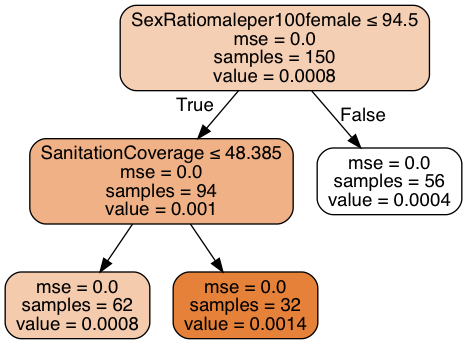

In [22]:
path = '/Users/kristikorsberg/Downloads/simplified_master0911.csv'

obj = nepal_analysis(path, 'Chickenpox', 8, 2, False)
rfr_score, oob, sig, rfr_mse = obj.rfr_()
dtr_score, img, dtr_mse = obj.dtr_()
img

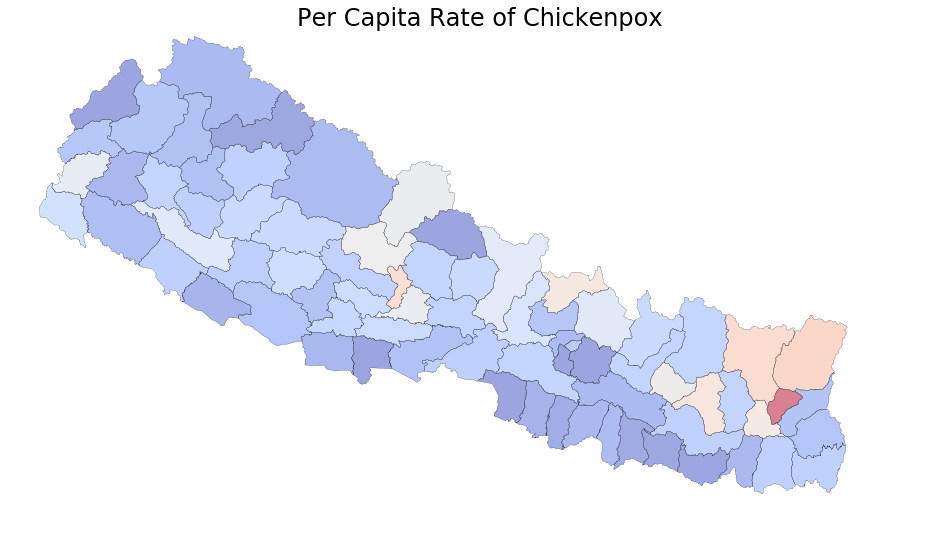

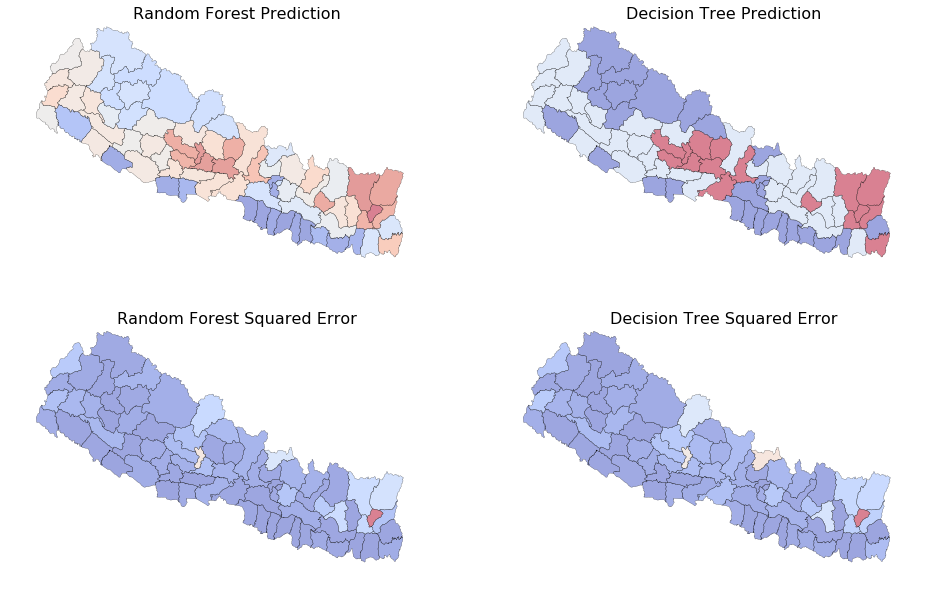

In [23]:
rfr_join = nepal.join(rfr_mse.groupby(rfr_mse.index).mean())
dtr_join = nepal.join(dtr_mse.groupby(dtr_mse.index).mean())

fig, (ax1) = plt.subplots(figsize=(16, 9))
rfr_join.plot(column='Obs', cmap='coolwarm', linewidth=0.2, ax=ax1)
ax1.set_title('Per Capita Rate of Chickenpox', size=24)
ax1.axis('off')

fig, ((ax1, ax2),
      (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
rfr_join.plot(column='Pred', cmap='coolwarm', linewidth=0.2, ax=ax1)
ax1.set_title('Random Forest Prediction', size=16)
dtr_join.plot(column='Pred', cmap='coolwarm', linewidth=0.2, ax=ax2)
ax2.set_title('Decision Tree Prediction', size=16)
rfr_join.plot(column='DiffSqr', cmap='coolwarm', linewidth=0.2, ax=ax3)
ax3.set_title('Random Forest Squared Error', size=16)
dtr_join.plot(column='DiffSqr', cmap='coolwarm', linewidth=0.2, ax=ax4)
ax4.set_title('Decision Tree Squared Error', size=16)

for ax in fig.axes:
    ax.axis('off')

In [24]:
mean = rfr_mse.groupby(rfr_mse.index).mean()
print sum([elem for elem in mean['DiffSqr']])/len(mean)
mean[mean['DiffSqr']==min(mean['DiffSqr'])]

3.12220862014e-07


,Obs,Pred,Diff,DiffSqr,DiffSqrNorm
Bhaktapur,0.000624,0.000612,0.000012,5.224406e-10,-0.470143


In [25]:
mean = dtr_mse.groupby(dtr_mse.index).mean()
print sum([elem for elem in mean['DiffSqr']])/len(mean)
mean[mean['DiffSqr']==min(mean['DiffSqr'])]

3.55430811788e-07


,Obs,Pred,Diff,DiffSqr,DiffSqrNorm
Bhojpur,0.000786,0.000805,-0.000019,3.501755e-10,-0.522687
